# Code to visualise Sentinel, ERS and Envisat scenes and masks

In [1]:
import os
import glob
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from rasterio.plot import show
from pathlib import Path
import re

In [2]:
base_dir = "/gws/nopw/j04/iecdt/amorgan/benchmark_data_CB"

satellites = {
    "Sentinel-1": os.path.join(base_dir, "Sentinel-1"),
    "ERS": os.path.join(base_dir, "ERS"), 
    "Envisat": os.path.join(base_dir, "Envisat")
}

In [3]:
def find_matching_mask(scene_file, mask_files):
    """Find a mask file that corresponds to the given scene file"""
    scene_basename = os.path.basename(scene_file)
    masks_dir = os.path.dirname(mask_files[0])
    
    # Option 1: Direct match (just different directory)
    direct_match = os.path.join(masks_dir, scene_basename)
    if direct_match in mask_files:
        return direct_match
    
    return None

In [4]:
def visualize_satellite_data(satellite_name, satellite_dir):
    """Visualize one scene and its mask for a given satellite"""
    # Construct paths for scenes and masks
    scenes_dir = os.path.join(satellite_dir, "scenes")
    masks_dir = os.path.join(satellite_dir, "masks")
    
    # Check if directories exist
    print(f"\nChecking {satellite_name} directories:")
    if not os.path.exists(scenes_dir):
        print(f"❌ Scenes directory not found: {scenes_dir}")
        return False
    else:
        print(f"✓ Found scenes directory: {scenes_dir}")
    
    if not os.path.exists(masks_dir):
        print(f"❌ Masks directory not found: {masks_dir}")
        return False
    else:
        print(f"✓ Found masks directory: {masks_dir}")
    
    # Get scene files
    scene_files = glob.glob(os.path.join(scenes_dir, "*.tif"))
    if not scene_files:
        print(f"❌ No scene files found for {satellite_name}.")
        return False
    else:
        print(f"✓ Found {len(scene_files)} scene files")
    
    # Get mask files
    mask_files = glob.glob(os.path.join(masks_dir, "*.tif"))
    if not mask_files:
        print(f"❌ No mask files found for {satellite_name}.")
        return False
    else:
        print(f"✓ Found {len(mask_files)} mask files")
    
    # Take the first scene file
    first_scene_file = scene_files[0]
    print(f"\nVisualizing {satellite_name} scene: {os.path.basename(first_scene_file)}")
    
    # Try to find matching mask
    matching_mask = find_matching_mask(first_scene_file, mask_files)
    
    if not matching_mask:
        # If no match found, just take the first mask
        matching_mask = mask_files[0]
        print(f"No direct match found. Using: {os.path.basename(matching_mask)}")
    else:
        print(f"Found matching mask: {os.path.basename(matching_mask)}")
    
    # Create visualization
    try:
        with rasterio.open(first_scene_file) as scene_src, rasterio.open(matching_mask) as mask_src:
            # Read the data
            scene_data = scene_src.read(1)  # Read the first band
            mask_data = mask_src.read(1)    # Read the first band
            
            # Print statistics
            print(f"\n{satellite_name} Scene statistics:")
            print(f"  Shape: {scene_data.shape}")
            print(f"  Min value: {scene_data.min()}")
            print(f"  Max value: {scene_data.max()}")
            print(f"  Mean value: {scene_data.mean():.2f}")
            
            print(f"\n{satellite_name} Mask statistics:")
            print(f"  Shape: {mask_data.shape}")
            print(f"  Min value: {mask_data.min()}")
            print(f"  Max value: {mask_data.max()}")
            print(f"  Mean value: {mask_data.mean():.2f}")
            
            # Create a figure with two subplots
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))
            fig.suptitle(f"{satellite_name} Data Visualization", fontsize=16)
            
            # Display the scene (with contrast adjustment)
            vmin = np.percentile(scene_data, 2)  # Clip bottom 2% for better contrast
            vmax = np.percentile(scene_data, 98)  # Clip top 2% for better contrast
            scene_img = ax1.imshow(scene_data, cmap='gray', vmin=vmin, vmax=vmax)
            ax1.set_title('Scene')
            plt.colorbar(scene_img, ax=ax1, shrink=0.5)
            
            # Display the mask
            mask_img = ax2.imshow(mask_data, cmap='viridis')
            ax2.set_title('Mask')
            plt.colorbar(mask_img, ax=ax2, shrink=0.5)
            
            # Add file names as subtitles
            ax1.text(0.5, -0.1, os.path.basename(first_scene_file), 
                    horizontalalignment='center', transform=ax1.transAxes, fontsize=8)
            ax2.text(0.5, -0.1, os.path.basename(matching_mask), 
                    horizontalalignment='center', transform=ax2.transAxes, fontsize=8)
            
            plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust for the suptitle
            plt.show()
            
            return True
    
    except Exception as e:
        print(f"Error visualizing {satellite_name} data: {str(e)}")
        return False

# First, print directory structure for debugging
print("Directory Structure Information:")
print("=" * 40)

for sat_name, sat_dir in satellites.items():
    if os.path.exists(sat_dir):
        print(f"✓ Found {sat_name} directory: {sat_dir}")
    else:
        print(f"❌ {sat_name} directory not found: {sat_dir}")



# First try primary structure
satellites_found = 0
for sat_name, sat_dir in satellites.items():
    if os.path.exists(sat_dir):
        if visualize_satellite_data(sat_name, sat_dir):
            satellites_found += 1

print("\nVisualization complete!")

Directory Structure Information:
✓ Found Sentinel-1 directory: /gws/nopw/j04/iecdt/amorgan/benchmark_data_CB/Sentinel-1
✓ Found ERS directory: /gws/nopw/j04/iecdt/amorgan/benchmark_data_CB/ERS
✓ Found Envisat directory: /gws/nopw/j04/iecdt/amorgan/benchmark_data_CB/Envisat

Checking Sentinel-1 directories:
✓ Found scenes directory: /gws/nopw/j04/iecdt/amorgan/benchmark_data_CB/Sentinel-1/scenes
✓ Found masks directory: /gws/nopw/j04/iecdt/amorgan/benchmark_data_CB/Sentinel-1/masks
✓ Found 81 scene files
✓ Found 81 mask files

Visualizing Sentinel-1 scene: S1A_EW_GRDM_1SDH_20170609T151156_20170609T151300_016958_01C3A7_84C0_Orb_NR_Cal_TC.tif
Found matching mask: S1A_EW_GRDM_1SDH_20170609T151156_20170609T151300_016958_01C3A7_84C0_Orb_NR_Cal_TC.tif

Sentinel-1 Scene statistics:
  Shape: (8897, 8709)
  Min value: 0.0
  Max value: 9.115446090698242
  Mean value: 0.18

Sentinel-1 Mask statistics:
  Shape: (8897, 8709)
  Min value: 0.0
  Max value: 1.0
  Mean value: 0.23


KeyboardInterrupt: 

### This is just a first glimpse at the entire raw dataset, there is some editing/change to be made.
### Visualise all images ( how to decide what to keep?)

Directory Structure Information:
✓ Found Sentinel-1 directory: /gws/nopw/j04/iecdt/amorgan/benchmark_data_CB/Sentinel-1
✓ Found ERS directory: /gws/nopw/j04/iecdt/amorgan/benchmark_data_CB/ERS
✓ Found Envisat directory: /gws/nopw/j04/iecdt/amorgan/benchmark_data_CB/Envisat

Checking Sentinel-1 directories:
✓ Found scenes directory: /gws/nopw/j04/iecdt/amorgan/benchmark_data_CB/Sentinel-1/scenes
✓ Found masks directory: /gws/nopw/j04/iecdt/amorgan/benchmark_data_CB/Sentinel-1/masks
✓ Found 81 scene files
✓ Found 81 mask files

Visualizing Sentinel-1 scene: S1A_EW_GRDM_1SDH_20170609T151156_20170609T151300_016958_01C3A7_84C0_Orb_NR_Cal_TC.tif
Found matching mask: S1A_EW_GRDM_1SDH_20170609T151156_20170609T151300_016958_01C3A7_84C0_Orb_NR_Cal_TC.tif

Sentinel-1 Scene statistics:
  Shape: (8897, 8709)
  Min value: 0.0
  Max value: 9.115446090698242
  Mean value: 0.18

Sentinel-1 Mask statistics:
  Shape: (8897, 8709)
  Min value: 0.0
  Max value: 1.0
  Mean value: 0.23


KeyboardInterrupt: 

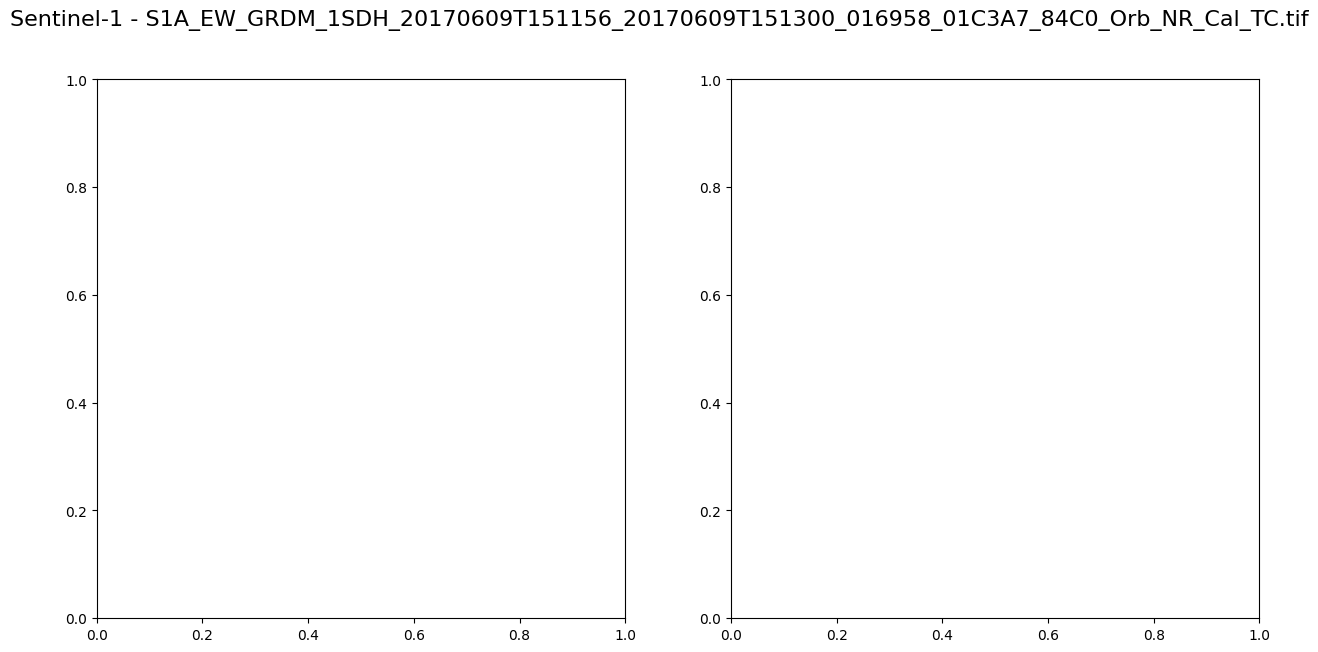

In [ ]:
def visualize_satellite_data(satellite_name, satellite_dir, max_images=None):
    """Visualize all scenes and their masks for a given satellite"""
    # Construct paths for scenes and masks
    scenes_dir = os.path.join(satellite_dir, "scenes")
    masks_dir = os.path.join(satellite_dir, "masks")
    
    # Check if directories exist
    print(f"\nChecking {satellite_name} directories:")
    if not os.path.exists(scenes_dir):
        print(f"❌ Scenes directory not found: {scenes_dir}")
        return False
    else:
        print(f"✓ Found scenes directory: {scenes_dir}")
    
    if not os.path.exists(masks_dir):
        print(f"❌ Masks directory not found: {masks_dir}")
        return False
    else:
        print(f"✓ Found masks directory: {masks_dir}")
    
    # Get scene files
    scene_files = glob.glob(os.path.join(scenes_dir, "*.tif"))
    if not scene_files:
        print(f"❌ No scene files found for {satellite_name}.")
        return False
    else:
        print(f"✓ Found {len(scene_files)} scene files")
    
    # Get mask files
    mask_files = glob.glob(os.path.join(masks_dir, "*.tif"))
    if not mask_files:
        print(f"❌ No mask files found for {satellite_name}.")
        return False
    else:
        print(f"✓ Found {len(mask_files)} mask files")
    
    # Limit the number of images to process if specified
    if max_images and max_images > 0:
        scene_files = scene_files[:max_images]
        print(f"Processing first {len(scene_files)} scenes")
    
    # Track success count
    successful_plots = 0
    
    # Process each scene file
    for scene_file in scene_files:
        print(f"\nVisualizing {satellite_name} scene: {os.path.basename(scene_file)}")
        
        # Try to find matching mask
        matching_mask = find_matching_mask(scene_file, mask_files)
        
        if not matching_mask:
            print(f"⚠️ No matching mask found for {os.path.basename(scene_file)}. Skipping.")
            continue
        else:
            print(f"Found matching mask: {os.path.basename(matching_mask)}")
        
        # Create visualization
        try:
            with rasterio.open(scene_file) as scene_src, rasterio.open(matching_mask) as mask_src:
                # Read the data
                scene_data = scene_src.read(1)  # Read the first band
                mask_data = mask_src.read(1)    # Read the first band
                
                # Print statistics
                print(f"\n{satellite_name} Scene statistics:")
                print(f"  Shape: {scene_data.shape}")
                print(f"  Min value: {scene_data.min()}")
                print(f"  Max value: {scene_data.max()}")
                print(f"  Mean value: {scene_data.mean():.2f}")
                
                print(f"\n{satellite_name} Mask statistics:")
                print(f"  Shape: {mask_data.shape}")
                print(f"  Min value: {mask_data.min()}")
                print(f"  Max value: {mask_data.max()}")
                print(f"  Mean value: {mask_data.mean():.2f}")
                
                # Create a figure with two subplots
                fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))
                fig.suptitle(f"{satellite_name} - {os.path.basename(scene_file)}", fontsize=16)
                
                # Display the scene (with contrast adjustment)
                vmin = np.percentile(scene_data, 2)  # Clip bottom 2% for better contrast
                vmax = np.percentile(scene_data, 98)  # Clip top 2% for better contrast
                scene_img = ax1.imshow(scene_data, cmap='gray', vmin=vmin, vmax=vmax)
                ax1.set_title('Scene')
                plt.colorbar(scene_img, ax=ax1, shrink=0.5)
                
                # Display the mask
                mask_img = ax2.imshow(mask_data, cmap='viridis')
                ax2.set_title('Mask')
                plt.colorbar(mask_img, ax=ax2, shrink=0.5)
                
                # Add file names as subtitles
                ax1.text(0.5, -0.1, os.path.basename(scene_file), 
                        horizontalalignment='center', transform=ax1.transAxes, fontsize=8)
                ax2.text(0.5, -0.1, os.path.basename(matching_mask), 
                        horizontalalignment='center', transform=ax2.transAxes, fontsize=8)
                
                plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust for the suptitle
                plt.show()
                
                successful_plots += 1
        
        except Exception as e:
            print(f"Error visualizing scene {os.path.basename(scene_file)}: {str(e)}")
    
    print(f"\nSuccessfully plotted {successful_plots} out of {len(scene_files)} scenes for {satellite_name}")
    return successful_plots > 0


# First, print directory structure for debugging
print("Directory Structure Information:")
print("=" * 40)

for sat_name, sat_dir in satellites.items():
    if os.path.exists(sat_dir):
        print(f"✓ Found {sat_name} directory: {sat_dir}")
    else:
        print(f"❌ {sat_name} directory not found: {sat_dir}")

# Option 1: Plot all images individually (interactive mode)
def plot_all_interactively(max_per_satellite=None):
    """Plot all images interactively one by one"""
    satellites_found = 0
    for sat_name, sat_dir in satellites.items():
        if os.path.exists(sat_dir):
            if visualize_satellite_data(sat_name, sat_dir, max_images=max_per_satellite):
                satellites_found += 1
    
    print(f"\nVisualization complete! Processed {satellites_found} satellites.")

# To plot interactively (one by one with plt.show()):
plot_all_interactively(max_per_satellite=None)  # Set to a number to limit images per satellite


### Visualise the different bands in the dataset
Bands/Channels included in the data:

-Sentinel-1: HH, HV, DEM, HH/HV

-ERS: VV, DEM

-Envisat: VV, DEM

# DONT RUN YET AS NEED TO CHECK IF THIS OVERWRITES ORIGINAL NAMES

### Generate consistent file naming system of form:
 SAT_[SATELLITE-ID]_YYYY-MM-DD_[original-filename]
Where:

[SATELLITE-ID] is either "S1" (Sentinel-1), "ERS" (ERS), or "ENV" (Envisat)
[YYYY-MM-DD] is the acquisition date extracted from the original filename
[original-filename] is the original filename for reference

In [ ]:
# Define consistent band naming
BAND_MAPPING = {
    "Sentinel-1": {
        "HH": 1,  # First band in Sentinel-1 data is HH polarization
        "HV": 2,  # Second band is HV polarization
        "DEM": 3, # Third band is DEM (Digital Elevation Model)
        "RATIO": 4 # Fourth band is HH/HV ratio
    },
    "ERS": {
        "VV": 1,  # First band in ERS data is VV polarization
        "DEM": 2  # Second band is DEM
    },
    "Envisat": {
        "VV": 1,  # First band in Envisat data is VV polarization
        "DEM": 2  # Second band is DEM
    }
}

# Standardized naming convention
def generate_standardized_filename(original_filename, satellite):
    """Generate a standardized filename from the original"""
    if satellite == "Sentinel-1":
        # Extract date from Sentinel-1 filenames
        match = re.search(r'(\d{8}T\d{6})', original_filename)
        if match:
            date_str = match.group(1)
            date_formatted = f"{date_str[:4]}-{date_str[4:6]}-{date_str[6:8]}"
            return f"SAT_S1_{date_formatted}_{os.path.basename(original_filename)}"
    else:  # ERS or Envisat
        # Extract date from ERS/Envisat filenames
        match = re.search(r'(\d{8})', original_filename)
        if match:
            date_str = match.group(1)
            date_formatted = f"{date_str[:4]}-{date_str[4:6]}-{date_str[6:8]}"
            satellite_short = "ERS" if satellite == "ERS" else "ENV"
            return f"SAT_{satellite_short}_{date_formatted}_{os.path.basename(original_filename)}"
    
    # Fallback if no date found
    return f"SAT_{satellite[:3].upper()}_{os.path.basename(original_filename)}"

def find_matching_mask(scene_file, mask_files):
    """Find a mask file that corresponds to the given scene file"""
    scene_basename = os.path.basename(scene_file)
    masks_dir = os.path.dirname(mask_files[0])
    
    # Option 1: Direct match (just different directory)
    direct_match = os.path.join(masks_dir, scene_basename)
    if direct_match in mask_files:
        return direct_match
    
    # Option 2: Compare dates if present in the filename
    date_pattern = re.compile(r'\d{8}T\d{6}|\d{8}')
    scene_dates = date_pattern.findall(scene_basename)
    
    if scene_dates:
        for mask_file in mask_files:
            mask_basename = os.path.basename(mask_file)
            for date in scene_dates:
                if date in mask_basename:
                    return mask_file
    
    return None



Directory Structure Information:
✓ Found Sentinel-1 directory: /gws/nopw/j04/iecdt/amorgan/benchmark_data_CB/Sentinel-1
✓ Found ERS directory: /gws/nopw/j04/iecdt/amorgan/benchmark_data_CB/ERS
✓ Found Envisat directory: /gws/nopw/j04/iecdt/amorgan/benchmark_data_CB/Envisat


## Checking different bands

Directory Structure Information:
✓ Found Sentinel-1 directory: /gws/nopw/j04/iecdt/amorgan/benchmark_data_CB/Sentinel-1

Processing first scene for Sentinel-1...
First scene: S1A_EW_GRDM_1SDH_20170609T151156_20170609T151300_016958_01C3A7_84C0_Orb_NR_Cal_TC.tif
Using mask: S1A_EW_GRDM_1SDH_20170609T151156_20170609T151300_016958_01C3A7_84C0_Orb_NR_Cal_TC.tif
Number of bands in scene: 4
  DEM stats - Min: -32767.00, Max: 1288.92, Mean: -762.67
  DEM display range: 0.00 to 600.00


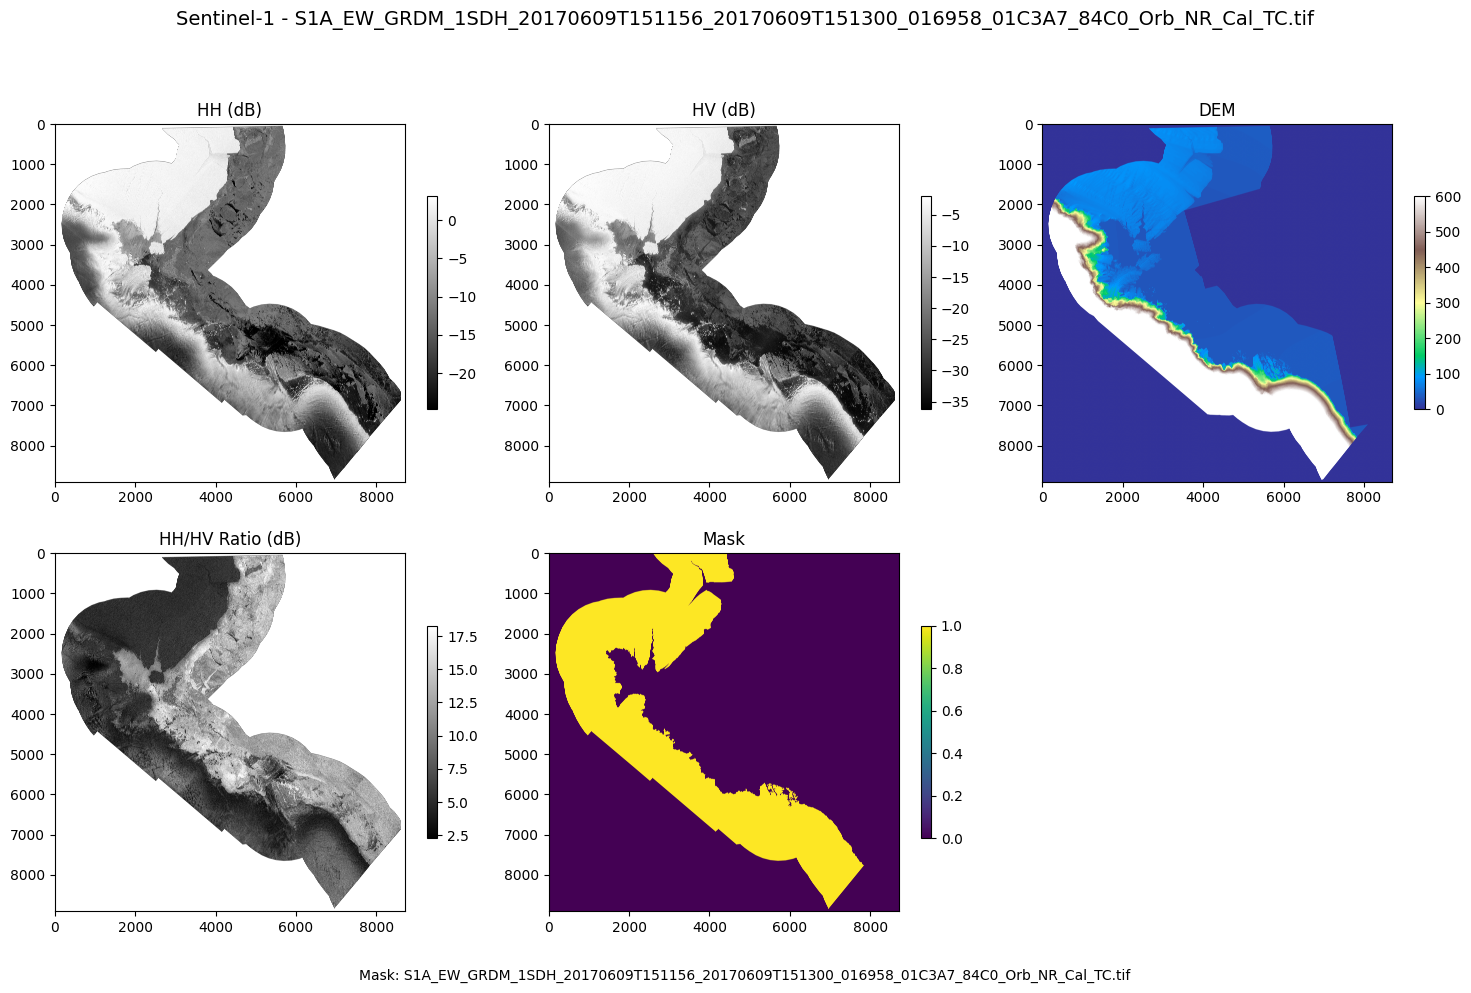

✓ Successfully visualized first Sentinel-1 scene with all bands

✓ Found ERS directory: /gws/nopw/j04/iecdt/amorgan/benchmark_data_CB/ERS

Processing first scene for ERS...
First scene: CG_prepro_SAR_IMP_1PNESA19961029_142649_00000018A016_00110_07980_0000_cropped.tif
Using mask: CG_prepro_SAR_IMP_1PNESA19961029_142649_00000018A016_00110_07980_0000_cropped.tif


/home/users/amorgan/benchmark_CB_AM/venv/lib/python3.10/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Number of bands in scene: 2
  DEM stats - Min: -28.03, Max: 676.63, Mean: 60.60
  DEM display range: 0.00 to 600.00


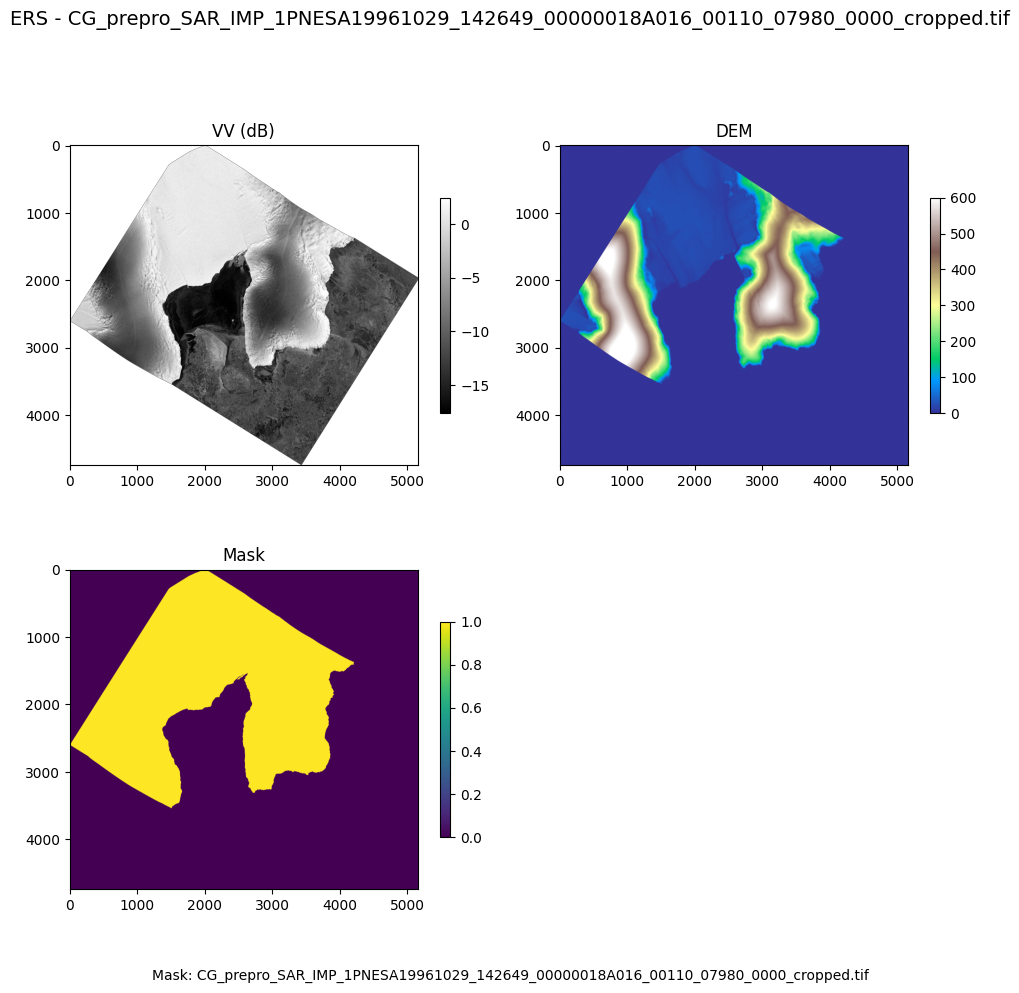

✓ Successfully visualized first ERS scene with all bands

✓ Found Envisat directory: /gws/nopw/j04/iecdt/amorgan/benchmark_data_CB/Envisat

Processing first scene for Envisat...
First scene: prepro_ASA_IMP_1PNESA20060205_133956_000000182044_00482_20576_0000_cropped.tif
Using mask: prepro_ASA_IMP_1PNESA20060205_133956_000000182044_00482_20576_0000_cropped.tif
Number of bands in scene: 2
  DEM stats - Min: -42.09, Max: 642.00, Mean: 33.39
  DEM display range: 0.00 to 600.00


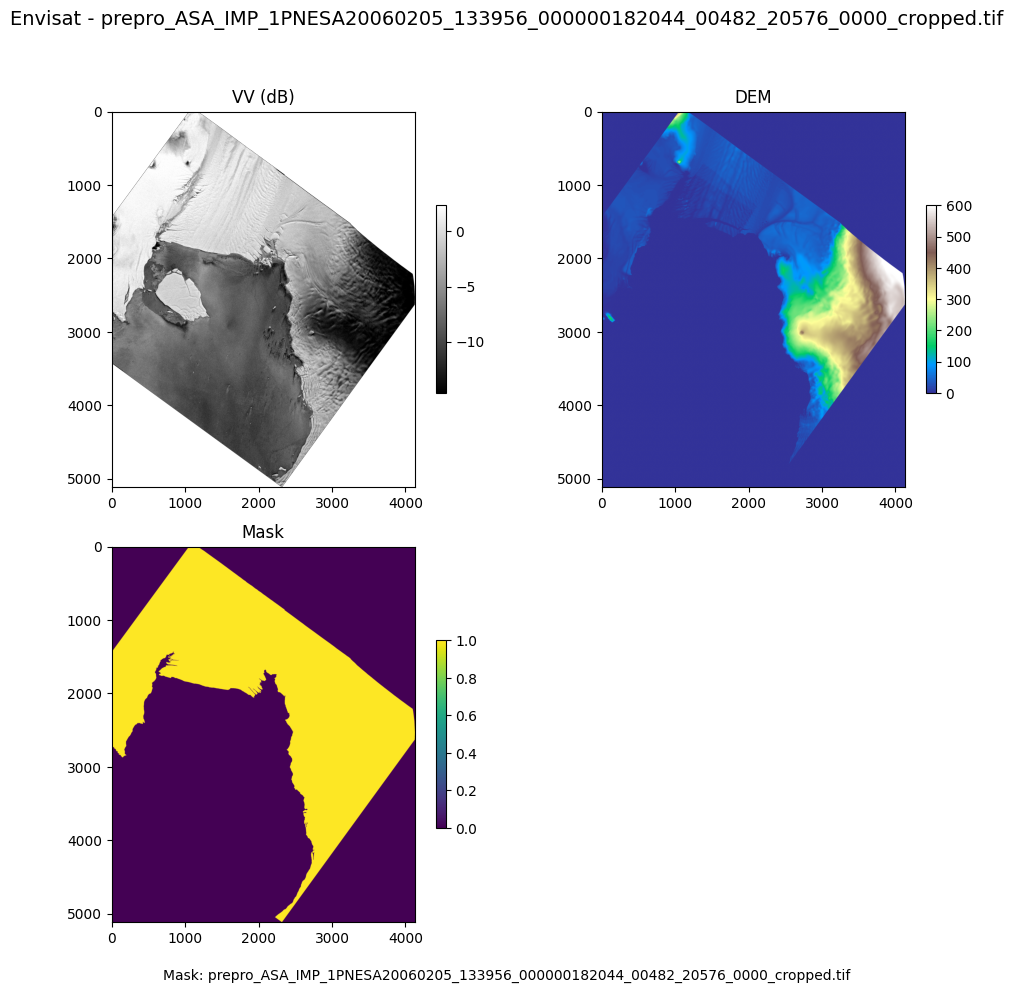

✓ Successfully visualized first Envisat scene with all bands



In [4]:
def convert_to_db(sigma0):
    """Convert sigma0 to decibels (dB)"""
    # Replace invalid values (≤ 0) with NaN
    sigma0 = np.where(sigma0 > 0, sigma0, np.nan)
    # Convert to dB
    return 10 * np.log10(sigma0)

def get_dem_display_range(dem_data, sat_name):
    """Get appropriate min/max values for DEM visualization based on satellite"""
    
    # For Sentinel-1, we need custom handling due to the negative values issue
    if sat_name == "Sentinel-1":
        # Check if DEM has extreme negative values
        min_val = np.nanmin(dem_data)
        
        if min_val < -1000:  # If there are very negative values
            # Find reasonable bounds using percentiles
            vmin = max(0, np.nanpercentile(dem_data, 5))  # Use 5th percentile or 0, whichever is higher
            vmax = min(600, np.nanpercentile(dem_data, 95))  # Cap at 600 for consistency with other satellites
            
            # If the upper bound is too low, use a default range
            if vmax < 100:
                vmin = 0
                vmax = 600
        else:
            # For DEM without extreme values, use standard range
            vmin = 0
            vmax = max(600, np.nanpercentile(dem_data, 95))
    else:
        # For ERS and Envisat, use standard range
        vmin = 0
        vmax = max(600, np.nanpercentile(dem_data, 95))
    
    return vmin, vmax

def visualize_first_scene_all_satellites():
    """Visualize the first scene from each satellite, showing all bands and mask"""
    
    # Print directory structure for debugging
    print("Directory Structure Information:")
    print("=" * 40)
    
    for sat_name, sat_dir in satellites.items():
        if os.path.exists(sat_dir):
            print(f"✓ Found {sat_name} directory: {sat_dir}")
        else:
            print(f"❌ {sat_name} directory not found: {sat_dir}")
            continue
            
        scenes_dir = os.path.join(sat_dir, "scenes")
        masks_dir = os.path.join(sat_dir, "masks")
        
        if not (os.path.exists(scenes_dir) and os.path.exists(masks_dir)):
            print(f"❌ Required directories not found for {sat_name}")
            continue
            
        scene_files = glob.glob(os.path.join(scenes_dir, "*.tif"))
        mask_files = glob.glob(os.path.join(masks_dir, "*.tif"))
        
        if not scene_files or not mask_files:
            print(f"❌ No files found for {sat_name}")
            continue
            
        print(f"\nProcessing first scene for {sat_name}...")
        
        # Get first scene file
        first_scene = scene_files[0]
        scene_basename = os.path.basename(first_scene)
        print(f"First scene: {scene_basename}")
        
        # Find matching mask
        matching_mask = find_matching_mask(first_scene, mask_files)
        if not matching_mask:
            print(f"⚠️ No matching mask found for {scene_basename}. Using first available mask.")
            matching_mask = mask_files[0]
        
        mask_basename = os.path.basename(matching_mask)
        print(f"Using mask: {mask_basename}")
        
        try:
            with rasterio.open(first_scene) as scene_src, rasterio.open(matching_mask) as mask_src:
                # Get total number of bands
                num_bands = scene_src.count
                print(f"Number of bands in scene: {num_bands}")
                
                # Read all available bands
                bands = [scene_src.read(i+1) for i in range(num_bands)]
                
                # Get the mask data
                mask_data = mask_src.read(1)
                
                # Determine which bands to plot based on satellite
                if sat_name == "Sentinel-1":
                    band_names = ["HH", "HV", "DEM", "HH/HV Ratio"]
                else:  # ERS or Envisat
                    band_names = ["VV", "DEM"]
                
                # Create a figure with subplots for each band + mask
                total_plots = num_bands + 1  # All bands + mask
                rows = 2
                cols = (total_plots + 1) // 2
                
                fig = plt.figure(figsize=(5*cols, 10))
                fig.suptitle(f"{sat_name} - {scene_basename}", fontsize=14)
                
                # Plot each band
                for i in range(num_bands):
                    ax = plt.subplot(rows, cols, i+1)
                    
                    band_data = bands[i]
                    band_name = band_names[i] if i < len(band_names) else f"Band {i+1}"
                    
                    # Handle DEM bands specially
                    if band_name == "DEM":
                        title = band_name
                        cmap = 'terrain'
                        
                        # Get appropriate display range for DEM data
                        vmin, vmax = get_dem_display_range(band_data, sat_name)
                        
                        # Print DEM statistics for debugging
                        min_val = np.nanmin(band_data)
                        max_val = np.nanmax(band_data)
                        mean_val = np.nanmean(band_data)
                        print(f"  DEM stats - Min: {min_val:.2f}, Max: {max_val:.2f}, Mean: {mean_val:.2f}")
                        print(f"  DEM display range: {vmin:.2f} to {vmax:.2f}")
                        
                    # Convert to dB if it's a polarization band (not DEM)
                    elif band_name not in ["DEM"]:
                        band_data = convert_to_db(band_data)
                        title = f"{band_name} (dB)"
                        cmap = 'gray'
                        
                        # Display with contrast adjustment
                        vmin = np.nanpercentile(band_data, 2)
                        vmax = np.nanpercentile(band_data, 98)
                    else:
                        title = band_name
                        cmap = 'viridis'
                        vmin = np.nanpercentile(band_data, 2)
                        vmax = np.nanpercentile(band_data, 98)
                    
                    # Display the band
                    img = ax.imshow(band_data, cmap=cmap, vmin=vmin, vmax=vmax)
                    ax.set_title(title)
                    plt.colorbar(img, ax=ax, shrink=0.5)
                
                # Plot the mask
                ax_mask = plt.subplot(rows, cols, num_bands+1)
                mask_img = ax_mask.imshow(mask_data, cmap='viridis')
                ax_mask.set_title('Mask')
                plt.colorbar(mask_img, ax=ax_mask, shrink=0.5)
                
                # Add mask filename as subtitle
                plt.figtext(0.5, 0.01, f"Mask: {mask_basename}", 
                           ha='center', fontsize=10, wrap=True)
                
                # Adjust layout
                plt.tight_layout(rect=[0, 0.03, 1, 0.95])
                plt.show()
                
                print(f"✓ Successfully visualized first {sat_name} scene with all bands\n")
                
        except Exception as e:
            print(f"Error visualizing {sat_name} scene: {str(e)}")

# Run the visualization
visualize_first_scene_all_satellites()


### EXTRA: checking pixel size

In [4]:
def detect_background_value(image: np.ndarray) -> float:
    """
    Detect the background/nodata value in the image by sampling edge pixels.
    Returns the most common edge value.
    """
    h, w = image.shape[:2]
    edge_pixels = []
    # Top and bottom edges
    edge_pixels.extend(image[0, :].flatten())
    edge_pixels.extend(image[-1, :].flatten())
    # Left and right edges
    edge_pixels.extend(image[:, 0].flatten())
    edge_pixels.extend(image[:, -1].flatten())
    edge_pixels = np.array(edge_pixels)
    unique_vals, counts = np.unique(edge_pixels, return_counts=True)
    background_val = unique_vals[np.argmax(counts)]
    return float(background_val)

def visualize_satellite_data(satellite_name, satellite_dir):
    """Visualize one scene and its mask for a given satellite, including pixel and resolution information"""
    # Construct paths for scenes and masks
    scenes_dir = os.path.join(satellite_dir, "scenes")
    masks_dir = os.path.join(satellite_dir, "masks")
    
    # Check if directories exist
    print(f"\nChecking {satellite_name} directories:")
    if not os.path.exists(scenes_dir):
        print(f"❌ Scenes directory not found: {scenes_dir}")
        return False
    else:
        print(f"✓ Found scenes directory: {scenes_dir}")
    
    if not os.path.exists(masks_dir):
        print(f"❌ Masks directory not found: {masks_dir}")
        return False
    else:
        print(f"✓ Found masks directory: {masks_dir}")
    
    # Get scene files
    scene_files = glob.glob(os.path.join(scenes_dir, "*.tif"))
    if not scene_files:
        print(f"❌ No scene files found for {satellite_name}.")
        return False
    else:
        print(f"✓ Found {len(scene_files)} scene files")
    
    # Get mask files
    mask_files = glob.glob(os.path.join(masks_dir, "*.tif"))
    if not mask_files:
        print(f"❌ No mask files found for {satellite_name}.")
        return False
    else:
        print(f"✓ Found {len(mask_files)} mask files")
    
    # Take the first scene file
    first_scene_file = scene_files[0]
    print(f"\nVisualizing {satellite_name} scene: {os.path.basename(first_scene_file)}")
    
    # Try to find matching mask
    matching_mask = find_matching_mask(first_scene_file, mask_files)
    
    if not matching_mask:
        # If no match found, just take the first mask
        matching_mask = mask_files[0]
        print(f"No direct match found. Using: {os.path.basename(matching_mask)}")
    else:
        print(f"Found matching mask: {os.path.basename(matching_mask)}")
    
    # Create visualization
    try:
        with rasterio.open(first_scene_file) as scene_src, rasterio.open(matching_mask) as mask_src:
            # Read the data
            scene_data = scene_src.read(1)  # Read the first band
            mask_data = mask_src.read(1)    # Read the first band

            # Detect and print background value for the scene
            bg_val = detect_background_value(scene_data)
            print(f"\n{satellite_name} Detected background value (scene): {bg_val}")

            # Optionally, also check background for the mask
            mask_bg_val = detect_background_value(mask_data)
            print(f"{satellite_name} Detected background value (mask): {mask_bg_val}")

            
            # Get and print pixel size (resolution) information
            print(f"\n{satellite_name} Pixel and Resolution Information:")
            # Get the affine transform (contains resolution information)
            scene_transform = scene_src.transform
            mask_transform = mask_src.transform
            
            # Calculate pixel sizes in meters or degrees depending on CRS
            scene_pixel_width = abs(scene_transform[0])
            scene_pixel_height = abs(scene_transform[4])
            mask_pixel_width = abs(mask_transform[0])
            mask_pixel_height = abs(mask_transform[4])
            
            # Get Coordinate Reference System
            scene_crs = scene_src.crs
            mask_crs = mask_src.crs
            
            print(f"  Scene CRS: {scene_crs}")
            print(f"  Scene pixel width: {scene_pixel_width:.6f} units")
            print(f"  Scene pixel height: {scene_pixel_height:.6f} units")
            print(f"  Scene image dimensions: {scene_src.width} x {scene_src.height} pixels")
            print(f"  Scene total pixels: {scene_src.width * scene_src.height}")
            
            print(f"  Mask CRS: {mask_crs}")
            print(f"  Mask pixel width: {mask_pixel_width:.6f} units")
            print(f"  Mask pixel height: {mask_pixel_height:.6f} units")
            print(f"  Mask image dimensions: {mask_src.width} x {mask_src.height} pixels")
            print(f"  Mask total pixels: {mask_src.width * mask_src.height}")
            
            # Print spatial bounds
            print(f"\n{satellite_name} Spatial Bounds:")
            print(f"  Scene bounds: {scene_src.bounds}")
            print(f"  Mask bounds: {mask_src.bounds}")
            
            # Print statistics
            print(f"\n{satellite_name} Scene statistics:")
            print(f"  Shape: {scene_data.shape}")
            print(f"  Min value: {scene_data.min()}")
            print(f"  Max value: {scene_data.max()}")
            print(f"  Mean value: {scene_data.mean():.2f}")
            
            print(f"\n{satellite_name} Mask statistics:")
            print(f"  Shape: {mask_data.shape}")
            print(f"  Min value: {mask_data.min()}")
            print(f"  Max value: {mask_data.max()}")
            print(f"  Mean value: {mask_data.mean():.2f}")
        
            
            return True
    
    except Exception as e:
        print(f"Error visualizing {satellite_name} data: {str(e)}")
        return False

# Helper function to print more detailed file information
def print_raster_info(file_path):
    """Print detailed information about a raster file"""
    try:
        with rasterio.open(file_path) as src:
            print(f"\nDetailed info for: {os.path.basename(file_path)}")
            print(f"  Driver: {src.driver}")
            print(f"  Dimensions: {src.width}x{src.height} pixels")
            print(f"  Coordinate Reference System (CRS): {src.crs}")
            print(f"  Transform (Affine): {src.transform}")
            
            # Pixel size calculation
            transform = src.transform
            pixel_width = abs(transform[0])
            pixel_height = abs(transform[4])
            print(f"  Pixel size: {pixel_width:.6f}x{pixel_height:.6f} units")
            
            # Units will depend on the CRS - could be degrees or meters
            if src.crs:
                units = "meters" if src.crs.is_projected else "degrees"
                print(f"  Units: {units}")
            
            print(f"  Bounds: {src.bounds}")
            print(f"  Number of bands: {src.count}")
            
            # Get datatype for each band
            dtypes = [src.dtypes[i] for i in range(src.count)]
            print(f"  Data types: {dtypes}")
            
            # Calculate size on disk
            file_size = os.path.getsize(file_path) / (1024 * 1024)  # in MB
            print(f"  File size: {file_size:.2f} MB")
            
            # Check for nodata values
            nodata_values = [src.nodata for i in range(src.count)]
            print(f"  NoData values: {nodata_values}")
            
            return True
    except Exception as e:
        print(f"Error reading raster info: {str(e)}")
        return False

# First, print directory structure for debugging
print("Directory Structure Information:")
print("=" * 40)

for sat_name, sat_dir in satellites.items():
    if os.path.exists(sat_dir):
        print(f"✓ Found {sat_name} directory: {sat_dir}")
    else:
        print(f"❌ {sat_name} directory not found: {sat_dir}")

# Display detailed information for the first file from each satellite
print("\nDetailed File Information:")
print("=" * 40)
for sat_name, sat_dir in satellites.items():
    scenes_dir = os.path.join(sat_dir, "scenes")
    if os.path.exists(scenes_dir):
        scene_files = glob.glob(os.path.join(scenes_dir, "*.tif"))
        if scene_files:
            print_raster_info(scene_files[0])

# # First try primary structure
# satellites_found = 0
# for sat_name, sat_dir in satellites.items():
#     if os.path.exists(sat_dir):
#         if visualize_satellite_data(sat_name, sat_dir):
#             satellites_found += 1

print("\nVisualization complete!")

Directory Structure Information:
✓ Found Sentinel-1 directory: /gws/nopw/j04/iecdt/amorgan/benchmark_data_CB/Sentinel-1
✓ Found ERS directory: /gws/nopw/j04/iecdt/amorgan/benchmark_data_CB/ERS
✓ Found Envisat directory: /gws/nopw/j04/iecdt/amorgan/benchmark_data_CB/Envisat

Detailed File Information:

Detailed info for: S1A_20170609_HH_EW_GRDM_1SDH_84C0.tif
  Driver: GTiff
  Dimensions: 8709x8897 pixels
  Coordinate Reference System (CRS): EPSG:3031
  Transform (Affine): | 40.00, 0.00, 2076223.51|
| 0.00,-40.00, 721794.69|
| 0.00, 0.00, 1.00|
  Pixel size: 40.000000x40.000000 units
  Units: meters
  Bounds: BoundingBox(left=2076223.5125708096, bottom=365914.6892874851, right=2424583.5125708096, top=721794.6892874851)
  Number of bands: 4
  Data types: ['float32', 'float32', 'float32', 'float32']
  File size: 1182.38 MB
  NoData values: [None, None, None, None]

Detailed info for: ERS_19911203_VV_RIS_1PNESA19911203.tif
  Driver: GTiff
  Dimensions: 4292x4270 pixels
  Coordinate Referenc

In [14]:
# print all values of image: /gws/nopw/j04/iecdt/amorgan/benchmark_data_CB/ERS/masks/ERS_19911203_VV_RIS_1PNESA19911203.tif
#and print the range of values
image = rasterio.open("/gws/nopw/j04/iecdt/amorgan/benchmark_data_CB/Sentinel-1/scenes/S1A_20170609_HH_EW_GRDM_1SDH_84C0.tif")
data = image.read(1)  # Read the first band
print("\nImage Data Statistics:")
print(f"  Shape: {data.shape}")
print(f"  Min value: {data.min()}")
print(f"  Max value: {data.max()}")
print(f"  Mean value: {data.mean():.2f}")
print(f"  Min value: {np.nanmin(data)}")
print(f"  Max value: {np.nanmax(data)}")
print(f"  Mean value: {np.nanmean(data):.2f}")
print(f"  Unique values: {np.unique(data[~np.isnan(data)])}")
print(f"  Unique values: {np.unique(data)}")
print(f"  Background value: {detect_background_value(data)}")
print(f"  Data type: {data.dtype}")
print(f"  Number of pixels: {data.size}")
print(f"  Pixel size: {image.transform[0]:.6f} x {image.transform[4]:.6f} units")
print(f"  CRS: {image.crs}")
print(f"  Bounds: {image.bounds}")
print(f"  File size: {os.path.getsize(image.name) / (1024 * 1024):.2f} MB")
print(f"  NoData value: {image.nodata}")
print(f"  Units: {'meters' if image.crs.is_projected else 'degrees'}")
print("All values in the image:")
print(data)

#are these a


Image Data Statistics:
  Shape: (8897, 8709)
  Min value: 0.0
  Max value: 9.115446090698242
  Mean value: 0.18
  Min value: 0.0
  Max value: 9.115446090698242
  Mean value: 0.18
  Unique values: [0.0000000e+00 2.4261426e-10 5.7175631e-10 ... 8.8318720e+00 9.0586157e+00
 9.1154461e+00]
  Unique values: [0.0000000e+00 2.4261426e-10 5.7175631e-10 ... 8.8318720e+00 9.0586157e+00
 9.1154461e+00]
  Background value: 0.0
  Data type: float32
  Number of pixels: 77483973
  Pixel size: 40.000000 x -40.000000 units
  CRS: EPSG:3031
  Bounds: BoundingBox(left=2076223.5125708096, bottom=365914.6892874851, right=2424583.5125708096, top=721794.6892874851)
  File size: 1182.38 MB
  NoData value: None
  Units: meters
All values in the image:
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


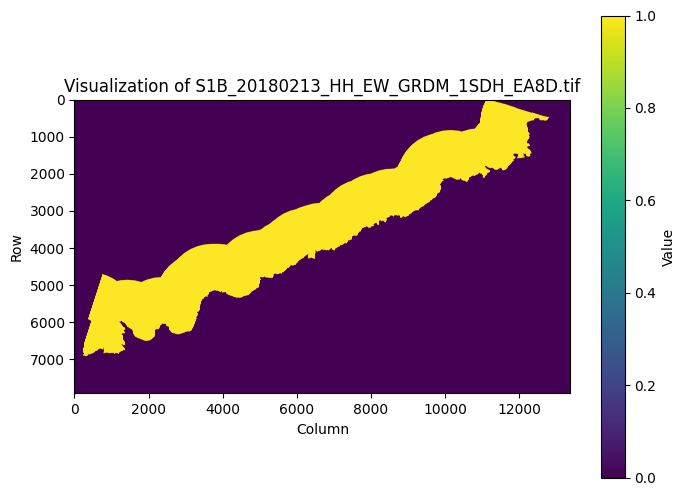

In [21]:
file = "/gws/nopw/j04/iecdt/amorgan/benchmark_data_CB/Sentinel-1/masks/S1B_20180213_HH_EW_GRDM_1SDH_EA8D.tif"

with rasterio.open(file) as src:
    data = src.read(1)
    plt.figure(figsize=(8, 6))
    plt.imshow(data, cmap='viridis')
    plt.title(f"Visualization of {os.path.basename(file)}")
    plt.colorbar(label='Value')
    plt.xlabel('Column')
    plt.ylabel('Row')
    plt.show()